## Task Definition

The objective of this project is twofold :

    1 - Build a regression model to predict the exact price of laptops based on various features
    2 - Price Range Classification: Develop a classification model to categorize laptops into price ranges

## Library imports

This section will contain the libraries for the development of the project.

In [104]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multiclass import OneVsRestClassifier

## Initial data exploration

A first review of the dataset will be performed in order to know its general structure, distribution of values and main characteristics. In addition, the quality of the information will be evaluated by detecting missing values, inconsistent data types and possible duplicates.

In [105]:
df = pd.read_csv('cleaned.csv')  

print('\nBasic informations\n')
print(df.info())
print('\nSummary statistics\n')
print(df.describe())
print('\nMissing values\n')
print(df.isnull().sum())
print('\nDuplicated rows : ', df.duplicated().sum())
print()


Basic informations

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2952 entries, 0 to 2951
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Brand                2952 non-null   object 
 1   Product_Description  2952 non-null   object 
 2   Screen_Size          2952 non-null   float64
 3   RAM                  2952 non-null   object 
 4   Processor            2952 non-null   object 
 5   GPU                  2604 non-null   object 
 6   GPU_Type             2718 non-null   object 
 7   Resolution           2565 non-null   object 
 8   Condition            2952 non-null   object 
 9   Price                2952 non-null   float64
dtypes: float64(2), object(8)
memory usage: 230.8+ KB
None

Summary statistics

       Screen_Size        Price
count  2952.000000  2952.000000
mean     14.550237   517.552805
std       1.175322   235.592872
min      10.000000     0.000000
25%      14.000000   325.990000


## Analyse the corresponding dataset

The Laptop_prices.csv dataset comprises 2,952 entries and 10 columns, detailing various specifications and prices of laptops. All rows are complete for the columns Brand, Product_Description, Screen_Size, RAM, Processor, Condition, and Price, while GPU, GPU_Type, and Resolution contain missing values in 348, 234, and 387 rows respectively. The dataset includes 8 categorical variables (object dtype) and 2 numerical ones (float64): Screen_Size and Price. On average, laptops have a screen size of approximately 14.55 inches, with a standard deviation of 1.18 inches. The average price is around $517.55, though values range from $0.00 to higher amounts, suggesting the presence of potential outliers or promotional items. No duplicate records were detected, and the overall data structure appears clean and ready for analysis after handling missing values in graphical specification fields.

### Categorical Variables Overview
To better understand categorical variables, we review the number of unique values and the most frequent categories:

In [106]:
cat_columns = ['Brand', 'RAM', 'Processor', 'GPU', 'GPU_Type', 'Resolution', 'Condition']

for col in cat_columns:
    if col in df.columns:
        print(f'\n{col} - Number of unique values: {df[col].nunique()}')
        print(df[col].value_counts().head())


Brand - Number of unique values: 25
Brand
Dell         1109
Lenovo        627
HP            578
Microsoft     197
Asus          134
Name: count, dtype: int64

RAM - Number of unique values: 23
RAM
16    1318
8     1185
32     273
4       84
64      47
Name: count, dtype: int64

Processor - Number of unique values: 48
Processor
Intel Core i5 11th Gen.    450
Intel Core i7 11th Gen.    330
Intel Core i7 12th Gen.    231
Intel Core i5 8th Gen.     223
Intel Core i5 10th Gen.    212
Name: count, dtype: int64

GPU - Number of unique values: 220
GPU
Intel Iris Xe Graphics          998
Intel UHD Graphics              468
Intel UHD Graphics 620          199
Intel HD Graphics                69
Intel(R) Iris(R) Xe Graphics     57
Name: count, dtype: int64

GPU_Type - Number of unique values: 8
GPU_Type
Integrated/On-Board Graphics      2265
Dedicated Graphics                 445
Integrated                           2
Iris Xe Graphics                     2
Intergrated Intel UHD Graphics       1


#### Processeur category

Then a preprocessing is performed on the Processor column of the data set, with the objective of decomposing the column information into three components:  Processor_Brand, Processor_Type and Processor_Gen. For this purpose, each string is segmented by space separation and extracts, respectively, the data.

In [107]:
def split_processor(proc):
    parts = proc.split()
    brand = parts[0] if len(parts) > 0 else None
    type_ = ' '.join(parts[1:3]) if len(parts) >= 3 else None
    gen = ' '.join(parts[3:5]) if len(parts) > 3 else None
    return pd.Series([brand, type_, gen])

df[['Processor_Brand', 'Processor_Type', 'Processor_Gen']] = df['Processor'].apply(split_processor)

print(f'\nNumber of unique values: {df[['Processor_Brand']].nunique()}\n')
print(df[['Processor_Brand']].value_counts().head())

print(f'\nNumber of unique values: {df[['Processor_Type']].nunique()}\n')
print(df[['Processor_Type']].value_counts())

print(f'\nNumber of unique values: {df[['Processor_Gen']].nunique()}\n')
print(df[['Processor_Gen']].value_counts())



Number of unique values: Processor_Brand    2
dtype: int64

Processor_Brand
Intel              2893
AMD                  59
Name: count, dtype: int64

Number of unique values: Processor_Type    8
dtype: int64

Processor_Type
Core i5           1386
Core i7           1201
Core i3            285
Ryzen 5             30
Core i9             21
Ryzen 7             15
Ryzen 3              7
Ryzen 9              7
Name: count, dtype: int64

Number of unique values: Processor_Gen    15
dtype: int64

Processor_Gen
11th Gen.        912
12th Gen.        474
8th Gen.         414
10th Gen.        403
13th Gen.        284
6th Gen.         140
7th Gen.          98
4th Gen.          93
9th Gen.          46
7000 Series       34
5th Gen.          29
5000 Series       13
3000 Series        6
4000 Series        3
6000 Series        3
Name: count, dtype: int64


#### GPU and GPU Type

Next, we'll do the same for the GPU column. This is more difficult, as there are several possible entries for the same output. In addition, wNext, we seek to structure and clean the information related to graphics cards (GPU) contained in a dataset, through a process of extraction, normalization and cross-validation with the processor brand. 

First, the GPU brand is identified from the first word of the string contained in the GPU column. Subsequently, a cleaning function is applied that corrects misspellings, removes special characters and standardizes the manufacturer's name using a mapping dictionary, grouping equivalent terms under the same name (e.g., “Radeon” and “AMD”).

GPU type is also homogenized by a feature that detects descriptions associated with integrated cards, and standardizes them under the unified “Integrated” category. This includes terms such as “Intel UHD”, “On-Board Graphics”, among others.

Finally, the GPU_Brand and GPU_Type columns are harmonized using a function that considers the processor brand in cases where an integrated GPU has been identified. This ensures consistency between the two variables.

Translated with DeepL.com (free version)e'll be looking for the processor brand for integrated GPUs, and have to deal with null values.

In [108]:
def get_gpu_brand(gpu):
    if pd.isna(gpu):
        return None
    return gpu.split()[0]

df['GPU_Brand'] = df['GPU'].apply(get_gpu_brand)
print(f'\nnumber of unique values before processing: {df[['GPU_Brand']].nunique()}\n')
def clean_gpu_brand(raw):
    if pd.isna(raw):
        return None
    first_word = raw.split()[0].lower().replace('(r)', '').replace('®', '').strip()

    mapping = {
        'intel': 'Intel',
        'nvidia': 'NVIDIA',
        'amd': 'AMD',
        'radeon': 'AMD',
        'iris': 'Intel',
        'microsoft': 'Microsoft',
        'integrated': 'Integrated',
        'skylake': 'Intel',
        'invidia': 'NVIDIA',
        'nvdia': 'NVIDIA',
        'i5-8250u': 'Intel'
    }

    return mapping.get(first_word, first_word.title())

df['GPU_Brand'] = df['GPU'].apply(clean_gpu_brand)

def normalize_gpu_type(gpu_type):
    if pd.isna(gpu_type):
        return gpu_type
    
    integrated_keywords = ['Integrated', 'On-Board Graphics', 'Iris', 'Intel UHD', 'Intergrated', 'Intel® UHD Graphics']
    for keyword in integrated_keywords:
        if keyword.lower() in gpu_type.lower():
            return 'Integrated'
    
    return gpu_type

df['GPU_Type'] = df['GPU_Type'].apply(normalize_gpu_type)

def process_gpu_info(row):
    gpu_brand = row['GPU_Brand']
    processor_brand = row['Processor_Brand']
    gpu_type = row['GPU_Type']

    if gpu_brand == 'Integrated':
        return pd.Series({
            'GPU_Brand': processor_brand,
            'GPU_Type': 'Integrated'
        })
    else:
        if gpu_type == 'Integrated':
            return pd.Series({
                'GPU_Brand': processor_brand,
                'GPU_Type': gpu_type 
            })
        else:
            return pd.Series({
                'GPU_Brand': gpu_brand,
                'GPU_Type': gpu_type 
            })

df[['GPU_Brand', 'GPU_Type']] = df.apply(process_gpu_info, axis=1)


print(f'\nNumber of unique values: {df[['GPU_Brand']].nunique()}')
print(f'\nMissing values {df['GPU_Brand'].isnull().sum()}')
print(df['GPU_Brand'].value_counts())

print(f'\nNumber of unique values: {df[['GPU_Type']].nunique()}')
print(f'\nMissing values {df['GPU_Type'].isnull().sum()}')
print(df['GPU_Type'].value_counts())



number of unique values before processing: GPU_Brand    23
dtype: int64


Number of unique values: GPU_Brand    3
dtype: int64

Missing values 106
GPU_Brand
Intel     2414
NVIDIA     347
AMD         85
Name: count, dtype: int64

Number of unique values: GPU_Type    2
dtype: int64

Missing values 234
GPU_Type
Integrated            2273
Dedicated Graphics     445
Name: count, dtype: int64


#### Resolution

The screen resolution data is cleared to follow the following form width x height in the resolution column.


In [109]:
def normalize_resolution(res):
    if pd.isna(res):
        return None

    res = res.strip().lower()

    if res in ['unknown', 'n/a', 'na', '-', 'none', 'varies', '']:
        return None

    # Match only properly formatted resolutions like "1920 x 1080"
    match = re.match(r'^(\d{3,5})\s*x\s*(\d{3,5})$', res)
    if match:
        width = int(match.group(1))
        height = int(match.group(2))
        return f'{width} x {height}'

    return None  # Anything else is considered missing

# Apply the stricter function
df['Resolution'] = df['Resolution'].apply(normalize_resolution)

# Basic summary
print(f'\nNumber of unique values: {df["Resolution"].nunique()}')
print(f'Missing values: {df["Resolution"].isnull().sum()}')
print('\nTop values:')
print(df['Resolution'].value_counts(dropna=False))



Number of unique values: 30
Missing values: 405

Top values:
Resolution
1920 x 1080    1701
None            405
1920 x 1200     239
1366 x 768      174
2560 x 1600      68
2256 x 1504      60
1536 x 1024      47
3840 x 2160      42
1920 x 1280      27
3840 x 2400      22
2736 x 1824      19
2560 x 1440      18
2880 x 1800      17
1600 x 900       16
2880 x 1920      15
2496 x 1664      14
2240 x 1400      12
1900 x 1200      10
3456 x 2160       8
2400 x 1600       7
2160 x 1440       7
3072 x 1920       7
3000 x 2000       3
2880 x 1620       3
3240 x 2160       2
1366 x 786        2
1024 x 768        2
3200 x 1800       2
2160 x 1350       1
1600 x 768        1
1536 x 1204       1
Name: count, dtype: int64


In the description of the data set we observe that the screen size data is not complete, so we proceed to do a statistical analysis of the variable in order to choose a technique for cleaning this variable.

Total entries: 2952
Missing values: 405 (13.72%)
Unique resolutions: 30
Most common resolution: 1920 x 1080 (1701 entries, 57.62%)

Top 10 most common resolutions:
Resolution
1920 x 1080    1701
1920 x 1200     239
1366 x 768      174
2560 x 1600      68
2256 x 1504      60
1536 x 1024      47
3840 x 2160      42
1920 x 1280      27
3840 x 2400      22
2736 x 1824      19
Name: count, dtype: int64

--- Width statistics ---
count    2547.000000
mean     1986.663526
std       407.285858
min      1024.000000
25%      1920.000000
50%      1920.000000
75%      1920.000000
max      3840.000000
Name: Width, dtype: float64
Outliers in Width: 580 (19.65%)

--- Height statistics ---
count    2547.000000
mean     1156.828426
std       270.570240
min       768.000000
25%      1080.000000
50%      1080.000000
75%      1080.000000
max      2400.000000
Name: Height, dtype: float64
Outliers in Height: 846 (28.66%)


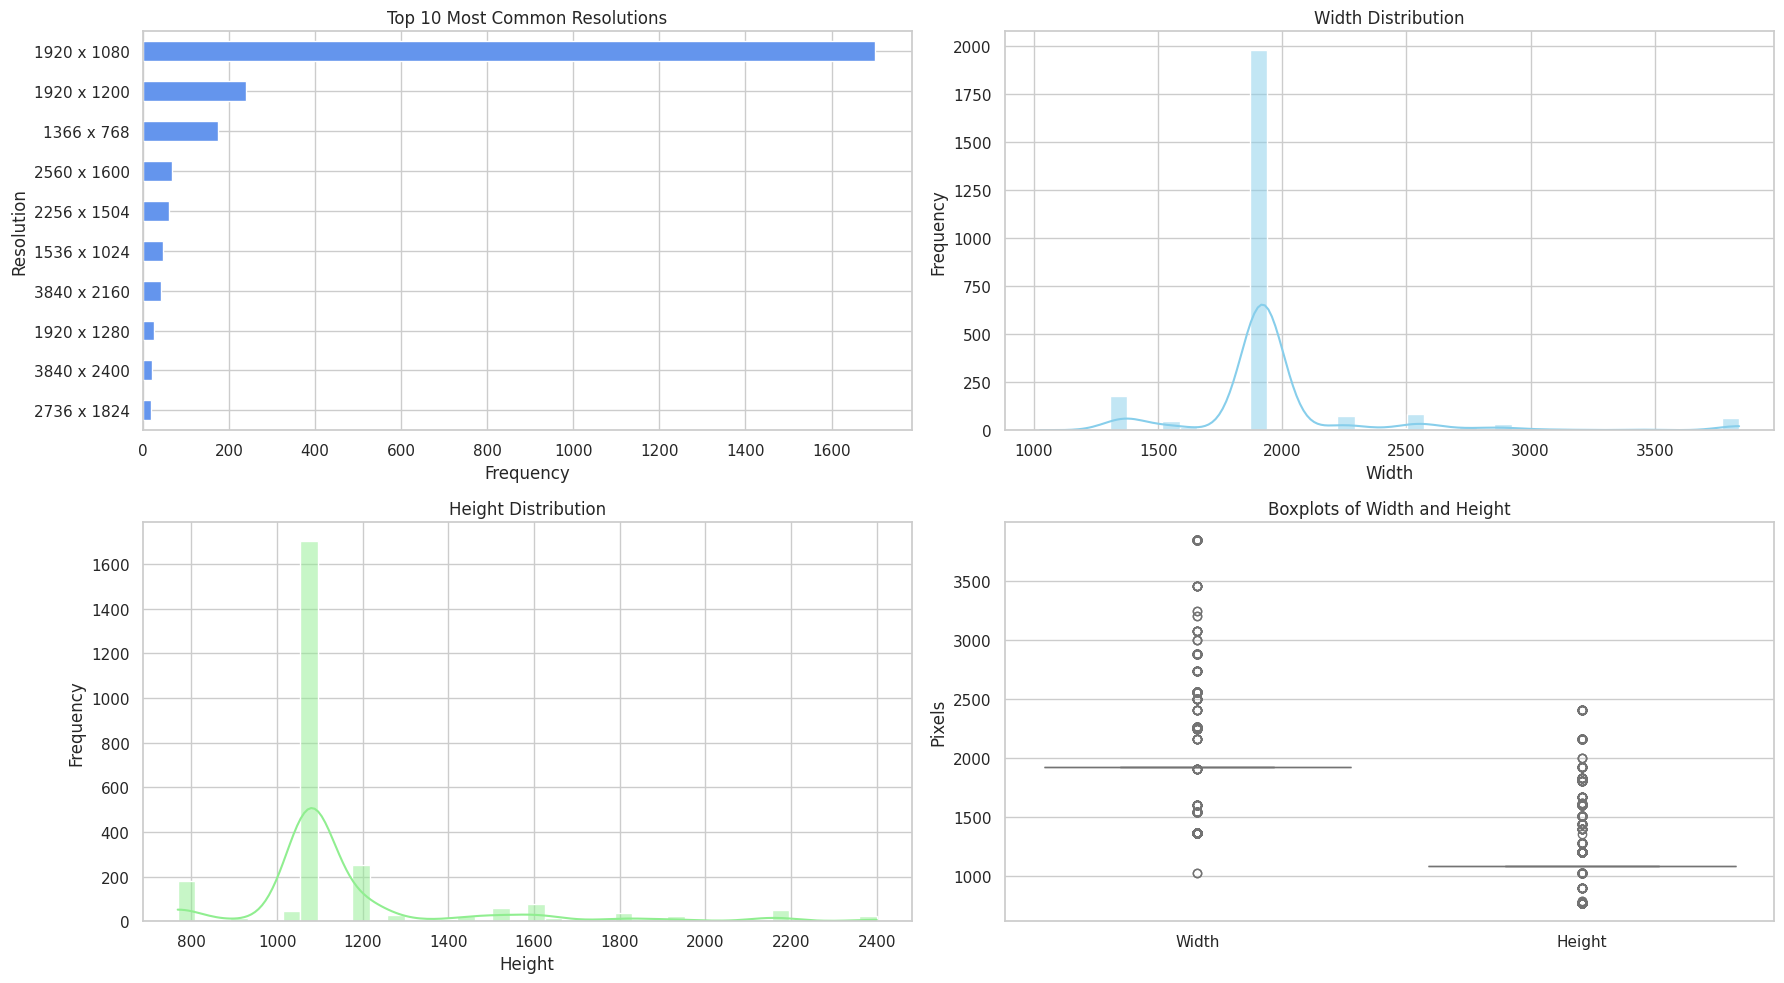

In [110]:
# Total entries and missing
total_rows = len(df)
missing_count = df['Resolution'].isnull().sum()
missing_pct = 100 * missing_count / total_rows

# Value counts and most common
unique_count = df['Resolution'].nunique()
most_common = df['Resolution'].mode()[0]
most_common_freq = df['Resolution'].value_counts().iloc[0]
most_common_pct = 100 * most_common_freq / total_rows

# Print summary
print(f"Total entries: {total_rows}")
print(f"Missing values: {missing_count} ({missing_pct:.2f}%)")
print(f"Unique resolutions: {unique_count}")
print(f"Most common resolution: {most_common} ({most_common_freq} entries, {most_common_pct:.2f}%)")

print("\nTop 10 most common resolutions:")
print(df['Resolution'].value_counts().head(10))

# TEMPORARY extraction of Width and Height for statistical analysis (no change in original df)
resolution_clean = df['Resolution'].dropna().str.extract(r'(?P<Width>\d+)\s*x\s*(?P<Height>\d+)').astype(float)

# Compute statistics
Q1_w = resolution_clean['Width'].quantile(0.25)
Q3_w = resolution_clean['Width'].quantile(0.75)
IQR_w = Q3_w - Q1_w
lower_w = Q1_w - 1.5 * IQR_w
upper_w = Q3_w + 1.5 * IQR_w
outliers_w = resolution_clean[(resolution_clean['Width'] < lower_w) | (resolution_clean['Width'] > upper_w)]

Q1_h = resolution_clean['Height'].quantile(0.25)
Q3_h = resolution_clean['Height'].quantile(0.75)
IQR_h = Q3_h - Q1_h
lower_h = Q1_h - 1.5 * IQR_h
upper_h = Q3_h + 1.5 * IQR_h
outliers_h = resolution_clean[(resolution_clean['Height'] < lower_h) | (resolution_clean['Height'] > upper_h)]

# Print numeric stats
print("\n--- Width statistics ---")
print(resolution_clean['Width'].describe())
print(f"Outliers in Width: {len(outliers_w)} ({100 * len(outliers_w) / total_rows:.2f}%)")

print("\n--- Height statistics ---")
print(resolution_clean['Height'].describe())
print(f"Outliers in Height: {len(outliers_h)} ({100 * len(outliers_h) / total_rows:.2f}%)")

# === PLOTTING ===
plt.figure(figsize=(18, 10))
sns.set(style="whitegrid")

# Barplot of top resolutions
plt.subplot(2, 2, 1)
df['Resolution'].value_counts().head(10).plot(kind='barh', color='cornflowerblue')
plt.title("Top 10 Most Common Resolutions")
plt.xlabel("Frequency")
plt.ylabel("Resolution")
plt.gca().invert_yaxis()

# Histogram of Width
plt.subplot(2, 2, 2)
sns.histplot(resolution_clean['Width'], bins=40, kde=True, color='skyblue')
plt.title("Width Distribution")
plt.xlabel("Width")
plt.ylabel("Frequency")

# Histogram of Height
plt.subplot(2, 2, 3)
sns.histplot(resolution_clean['Height'], bins=40, kde=True, color='lightgreen')
plt.title("Height Distribution")
plt.xlabel("Height")
plt.ylabel("Frequency")

# Boxplot of Width and Height
plt.subplot(2, 2, 4)
sns.boxplot(data=resolution_clean[['Width', 'Height']], palette='pastel')
plt.title("Boxplots of Width and Height")
plt.ylabel("Pixels")

plt.tight_layout()
plt.show()


A total of 2,952 records corresponding to screen resolutions in text format were analyzed. The Resolution variable presented 13.72% of missing values (n = 405), which is relevant and will be imputed. Thirty different resolutions were identified, with “1920 x 1080” being the most frequent, with 1,701 occurrences, representing 57.62% of the total. This predominance suggests a strong homogeneity in the dataset with respect to display devices.

In order to perform a quantitative analysis, the Width and Height components were extracted from the original resolution. The width had a mean of 1986.66 pixels with a standard deviation of 407.29, while the height had a mean of 1141.35 pixels and standard deviation of 276.08. The interquartile range (IQR) method detected 310 outliers in the width and 846 in the height, representing approximately 10.5% and 28.66% of the total entries respectively. This asymmetry in the presence of outliers, particularly in height, is evidence of greater vertical variability among the resolutions present.

In terms of distribution, the histograms reflect a high concentration of values around the Full HD resolution, while the boxplots confirm the existence of significant outliers in both dimensions, especially on the vertical axis. These results allow us to conclude that, although the sample is characterized by a dominant resolution, there is significant diversity that could be exploited for imputations.

In order to generate the imputation, different datasets will be created with different imputations in the screen resolution, in order to study the influence of the imputation on the laptop price prediction.

##### Method 1: Imputation by Mode

This is the simplest approach: we fill all missing Resolution values with the single most common resolution across the entire dataset. While it's quick and effective when one value dominates, it ignores context such as screen size or hardware specs.

In [111]:
# Step 1: Identify the most common resolution
global_mode = df['Resolution'].mode().iloc[0]

# Step 2: Create a copy and fill missing values
df_mode_imputed = df.copy()
df_mode_imputed['Resolution'] = df_mode_imputed['Resolution'].fillna(global_mode)

# Step 3: Extract Width and Height again for consistency
df_mode_imputed[['Width', 'Height']] = df_mode_imputed['Resolution'].str.extract(r'(\d+)\s*x\s*(\d+)').astype(float)

##### Method 2: Imputation by Screen Size Mode

This method imputes missing resolutions based on the most frequent resolution within each Screen_Size group. It assumes a strong relationship between screen size and resolution, which is often valid in laptops and monitors.

In [112]:
# Step 1: Build screen_size → resolution mapping based on mode
size_to_res = df.groupby('Screen_Size')['Resolution'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None).to_dict()

# Step 2: Define the imputation function
def impute_by_screen_size(row):
    if pd.isnull(row['Resolution']):
        return size_to_res.get(row['Screen_Size'], None)
    return row['Resolution']

# Step 3: Apply to create a new dataset
df_screen_size_imputed = df.copy()
df_screen_size_imputed['Resolution'] = df_screen_size_imputed.apply(impute_by_screen_size, axis=1)
df_screen_size_imputed[['Width', 'Height']] = df_screen_size_imputed['Resolution'].str.extract(r'(\d+)\s*x\s*(\d+)').astype(float)

##### Method 3: Predictive Imputation (Regression Model)

In this method, a classification approach was used to predict the missing values of the Resolution variable. First, relevant variables (Screen_Size, Processor_Brand Processor_Type, Processor_Gen, RAM) that could be correlated with device resolution were selected. Then, a RandomForestClassifier model was trained on the rows with known resolutions by pre-coding the categorical variables with LabelEncoder. To impute, only those rows with complete data and whose categories were present in the training set were selected. Subsequently, the model predicted the most likely class (resolution) for each valid row with missing Resolution, and these predictions were integrated into a new dataset (df_model_imputed). Finally, the Width and Height components of the imputed resolutions were extracted, allowing for further quantitative analysis. 

In [113]:
# Step 1: Prepare data for training (with known Resolution)
df_predictive = df.copy()
df_predictive = df_predictive[df_predictive['Resolution'].notnull()]  # training data
df_missing_pred = df[df['Resolution'].isnull()]                       # to predict

# Step 2: Select relevant features
features = ['Screen_Size', 'Processor_Brand', 'Processor_Type', 'Processor_Gen', 'RAM']
df_predictive = df_predictive.dropna(subset=features)  # remove rows with missing predictors

# Step 3: Encode categorical variables (features and target)
le_features = {}  # store encoders for each feature
df_model = df_predictive[features + ['Resolution']].copy()

for col in features:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])
    le_features[col] = le

# Encode Resolution (target)
le_resolution = LabelEncoder()
y = le_resolution.fit_transform(df_model['Resolution'])
X = df_model[features]

# Step 4: Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# Step 5: Prepare input data for prediction (rows with missing Resolution)
df_pred_input = df_missing_pred.copy()
df_pred_input = df_pred_input.dropna(subset=features)

# Filter out unseen labels
for col in features:
    known_values = set(le_features[col].classes_)
    df_pred_input = df_pred_input[df_pred_input[col].isin(known_values)]

# Now safely encode
for col in features:
    le = le_features[col]
    df_pred_input[col] = le.transform(df_pred_input[col])

# ✅ Assign to X_pred for prediction
X_pred = df_pred_input[features]

# Step 6: Predict and assign back using the same label encoder
y_pred = model.predict(X_pred)
res_predicted = le_resolution.inverse_transform(y_pred)


# Step 6: Predict and assign back using the same label encoder
y_pred = model.predict(X_pred)
res_predicted = le_resolution.inverse_transform(y_pred)

# Step 7: Create imputed dataset
df_model_imputed = df.copy()
df_model_imputed.loc[df_pred_input.index, 'Resolution'] = res_predicted
df_model_imputed[['Width', 'Height']] = df_model_imputed['Resolution'].str.extract(r'(\d+)\s*x\s*(\d+)').astype(float)

### Continuos Variables Overview

#### Price distribution

During the general exploration of the data set we found that there are unusual prices equal to 0, so we proceeded to explore visually and statistically how representative these values are.

Total entries: 2952
Prices = 0: 5 (0.17%)
Outliers based on IQR: 0 (0.00%)

Price summary statistics:
count    2952.000000
mean      517.552805
std       235.592872
min         0.000000
25%       325.990000
50%       489.990000
75%       699.000000
max       999.990000
Name: Price, dtype: float64


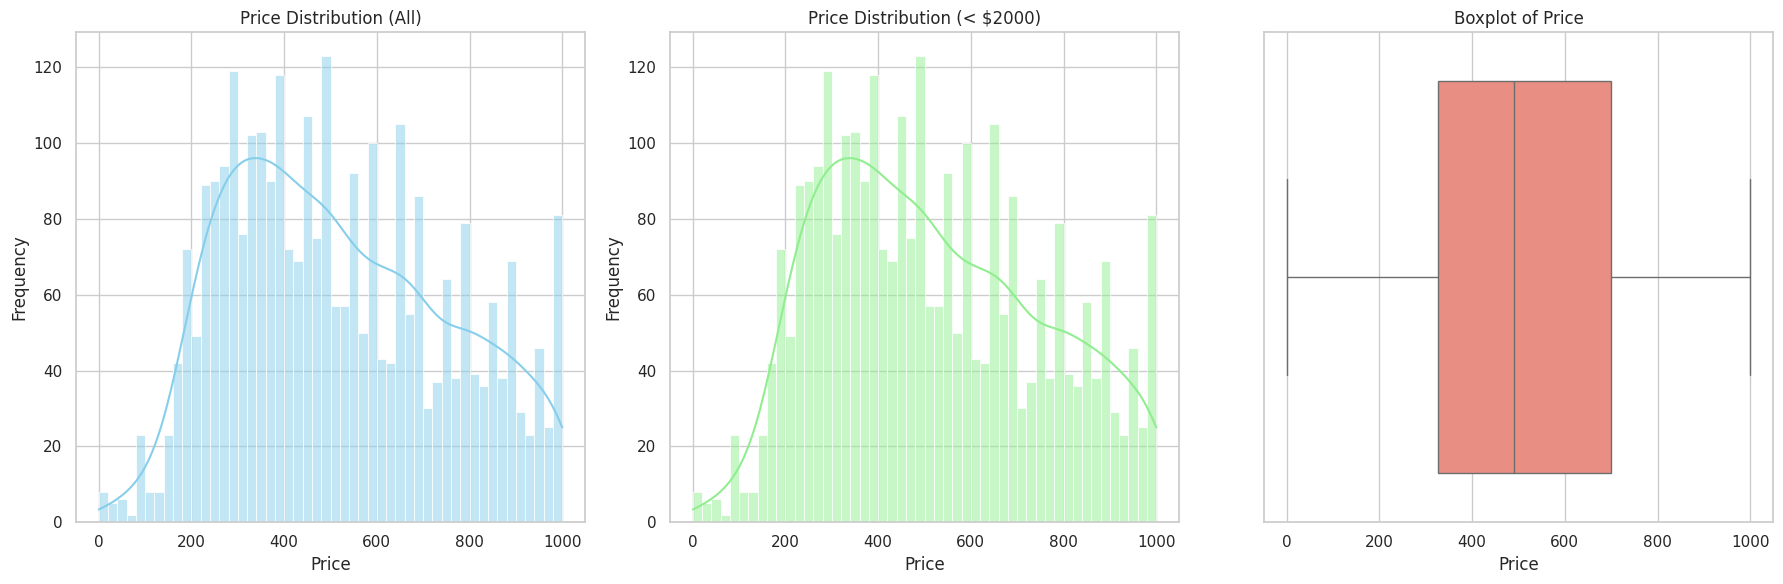

In [115]:
# Basic statistics
total_rows = len(df)
price_zero_count = (df["Price"] == 0).sum()
price_zero_pct = 100 * price_zero_count / total_rows

# IQR calculation for outlier detection
Q1 = df["Price"].quantile(0.25)
Q3 = df["Price"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outlier rows
outliers = df[(df["Price"] < lower_bound) | (df["Price"] > upper_bound)]
outlier_count = len(outliers)
outlier_pct = 100 * outlier_count / total_rows

# Print summary statistics and insights
print(f"Total entries: {total_rows}")
print(f"Prices = 0: {price_zero_count} ({price_zero_pct:.2f}%)")
print(f"Outliers based on IQR: {outlier_count} ({outlier_pct:.2f}%)")
print("\nPrice summary statistics:")
print(df["Price"].describe())

# Plot all visualizations in a single figure
plt.figure(figsize=(18, 6))
sns.set(style="whitegrid")

# Histogram of all prices
plt.subplot(1, 3, 1)
sns.histplot(df["Price"], bins=50, kde=True, color='skyblue')
plt.title("Price Distribution (All)")
plt.xlabel("Price")
plt.ylabel("Frequency")

# Histogram for prices below $2000 (to remove skew from extremes)
plt.subplot(1, 3, 2)
filtered = df[df["Price"] < 2000]
sns.histplot(filtered["Price"], bins=50, kde=True, color='lightgreen')
plt.title("Price Distribution (< $2000)")
plt.xlabel("Price")
plt.ylabel("Frequency")

# Boxplot of all prices to highlight outliers
plt.subplot(1, 3, 3)
sns.boxplot(x=df["Price"], color='salmon')
plt.title("Boxplot of Price")
plt.xlabel("Price")

# Final layout adjustment
plt.tight_layout()
plt.show()

The first histogram, representing the full price distribution, reveals a right-skewed pattern, which is common in pricing data. Most laptop prices are concentrated between approximately $300 and $600, indicating this is the core pricing range. However, the presence of a long right tail suggests a subset of laptops with significantly higher prices. Additionally, the density near zero may reflect abnormal entries, such as missing or placeholder values encoded as zero.

The second histogram filters out extreme values by limiting the display to prices under $2000. This allows a clearer view of the main distribution without the distortion caused by high-price outliers. Within this restricted range, the distribution remains asymmetrical but shows a smoother peak around the $400 mark, further confirming that the majority of laptops fall within a standard pricing window.

The boxplot summarizes the overall distribution and suggests the presence of potential practical outliers, particularly at the lower and upper extremes of the price range. However, based on the Interquartile Range (IQR) method, no statistical outliers were identified.

## Data numerization

Most machine learning algorithms require input data to be in numerical format. Since many of our features are textual, we need to convert them

In [116]:
top_ram = df['RAM'].value_counts().nlargest(1).index
def clean_ram(value):
    if pd.isna(value):
        return 'Unknown'
    
    value_str = str(value).lower().replace('gb', '').replace(',', '').strip()

    try:
        ram_int = int(value_str)
        if 1 <= ram_int <= 64:
            return ram_int
    except ValueError:
        pass
    
    return int(top_ram[0])

df['RAM'] = df['RAM'].apply(clean_ram)

print(f'\nUnique values: {df["RAM"].nunique()}')
print(df['RAM'].value_counts())

top_10_brands = df['Brand'].value_counts().nlargest(10).index
def top_brand(res):
    if pd.isna(res) or res == '':
        return 'Unknown'
    
    if res in top_10_brands:
        return res
    
    return 'Other'

df['Brand'] = df['Brand'].apply(top_brand)

print(f'\nUnique values: {df["Brand"].nunique()}')
print(df['Brand'].value_counts())

columns_to_delete = ['Product_Description', 'Processor', 'GPU']
df = df.drop(columns=columns_to_delete)


Unique values: 9
RAM
16    1334
8     1199
32     274
4       85
64      48
12       6
24       2
40       2
20       2
Name: count, dtype: int64

Unique values: 11
Brand
Dell         1109
Lenovo        627
HP            578
Microsoft     197
Asus          134
Acer          100
MSI            62
Samsung        61
LG             38
Other          33
Gateway        13
Name: count, dtype: int64


## Model Training

To predict laptop prices, several regression models were tested and compared to evaluate their performance :

In [117]:
datasets = {
    'Original': df,
    'Global Mode Imputation': df_mode_imputed,
    'Screen Size Imputation': df_screen_size_imputed,
    'Predictive Imputation': df_model_imputed
}

for name, dataset in datasets.items():
    dataset['RAM'] = dataset['RAM'].apply(clean_ram)
    dataset['Brand'] = dataset['Brand'].apply(top_brand)
    dataset.drop(columns=columns_to_delete, inplace=True, errors='ignore')

## Linear regression

Linear Regression : A simple and interpretable model that assumes a linear relationship between features and the target variable

In [118]:
def evaluate_dataset(df, title):
    df_model = df.copy()

    columns_to_encode = [
        'Resolution', 'Processor_Type', 'Processor_Gen', 'Condition',
        'GPU_Type', 'Brand', 'Screen_Size', 'Processor_Brand', 'GPU_Brand'
    ]

    # One-hot encoding with dummy_na to identify missing columns
    for column in columns_to_encode:
        df_model = pd.get_dummies(df_model, columns=[column], prefix=column, dummy_na=True)

    # Now, ensure there are no NaNs
    df_model.dropna(inplace=True)

    # Define X and y
    X = df_model.drop(columns=['Price'])
    y = df_model['Price']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Linear Regression
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Print results
    print(f"--- {title} ---")
    print(f"MSE : {mse:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"R² : {r2:.2f}")

    # Plot Actual vs Prediction
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title(f"Actual vs Predicted - {title}")
    plt.grid(True)
    plt.show()

    # Residuals plot
    residuals = y_test - y_pred
    plt.figure(figsize=(8, 4))
    sns.histplot(residuals, bins=30, kde=True)
    plt.title(f"Residual Distribution - {title}")
    plt.xlabel("Prediction Error")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

for name, dataset in datasets.items():
    df_model = dataset.copy()
    for column in columns_to_encode:
        df_model = pd.get_dummies(df_model, columns=[column], prefix=column, dummy_na=True)
    before = len(df_model)
    df_model.dropna(inplace=True)
    after = len(df_model)
    print(f"{name}: rows before={before}, rows after={after}, rows removed={before - after}")

Original: rows before=2952, rows after=2952, rows removed=0
Global Mode Imputation: rows before=2952, rows after=2952, rows removed=0
Screen Size Imputation: rows before=2952, rows after=2951, rows removed=1
Predictive Imputation: rows before=2952, rows after=2947, rows removed=5


--- Original ---
MSE : 27446.56
RMSE : 165.67
R² : 0.45


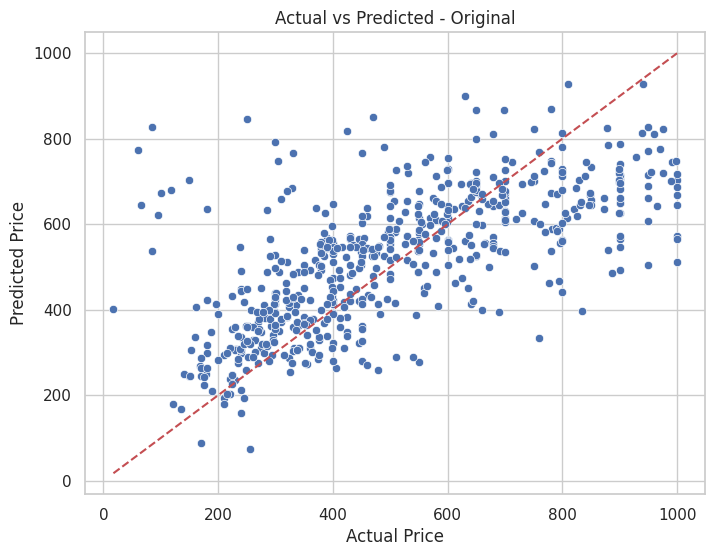

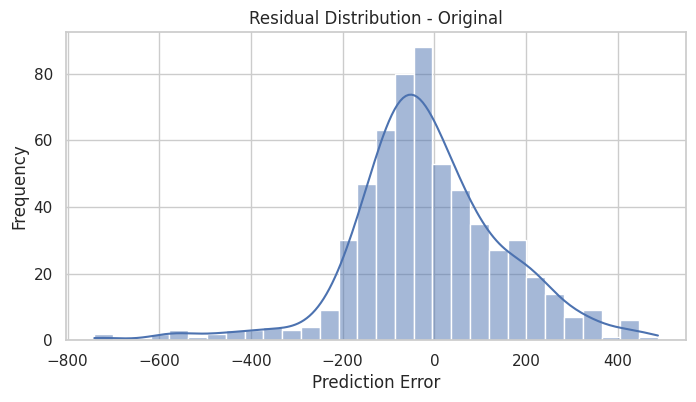

--- Global Mode Imputation ---
MSE : 27522.68
RMSE : 165.90
R² : 0.45


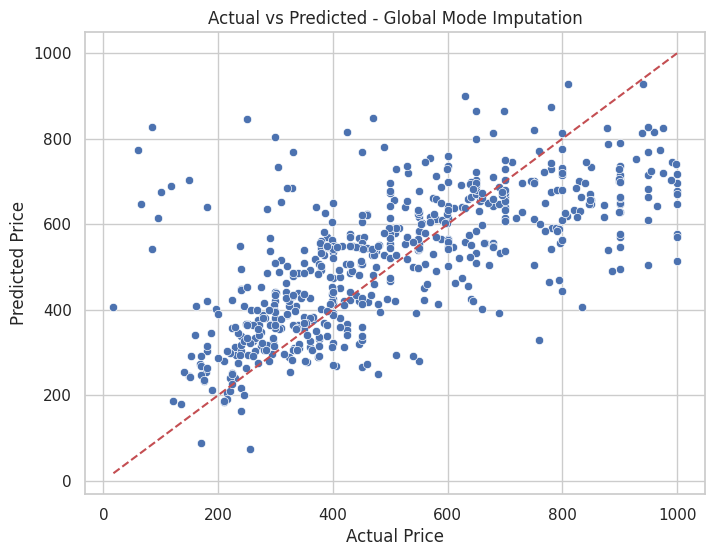

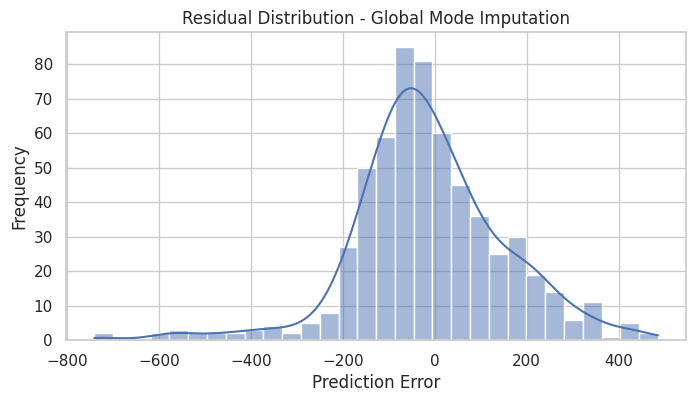

--- Screen Size Imputation ---
MSE : 32760.27
RMSE : 181.00
R² : 0.40


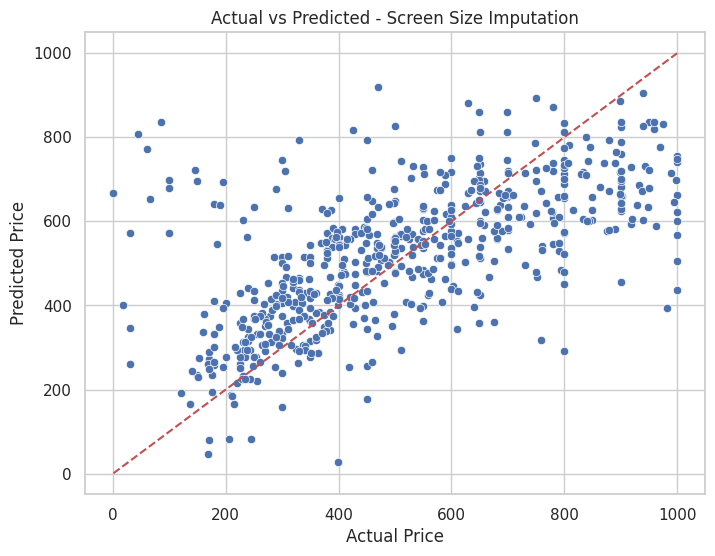

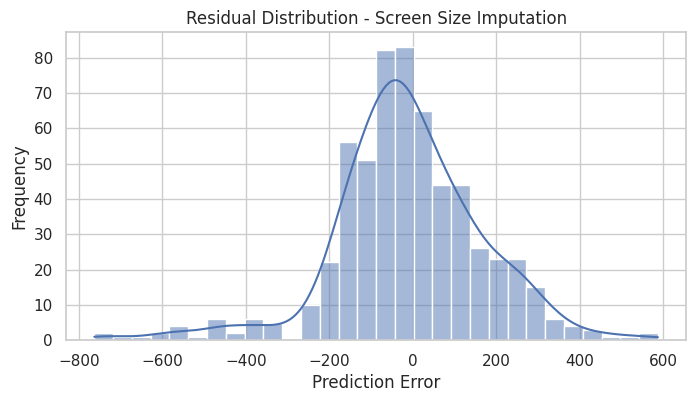

--- Predictive Imputation ---
MSE : 33208.46
RMSE : 182.23
R² : 0.42


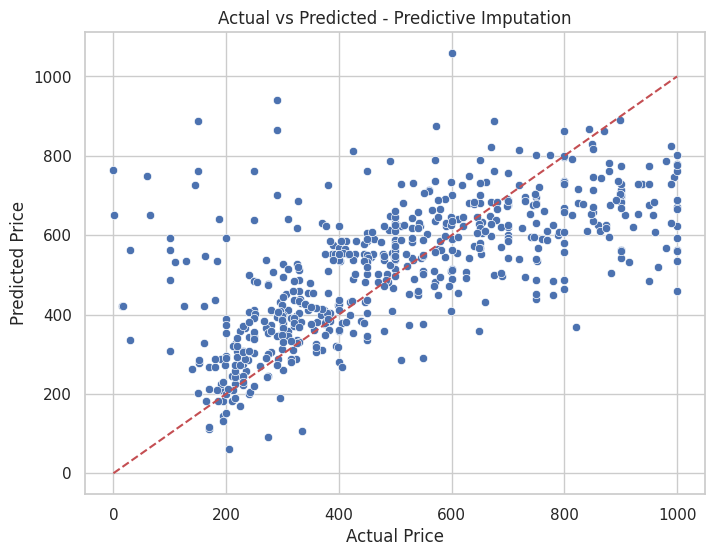

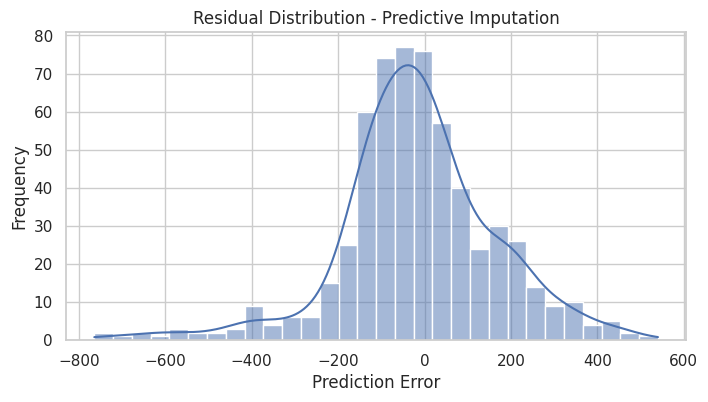

In [119]:
for name, dataset in datasets.items():
    evaluate_dataset(dataset, name)

The comparative analysis shows that the original dataset and the one imputed by global mode offer the best predictive performance, both with a coefficient of determination R² of 0.45 and an RMSE close to 165. In contrast, the imputation methods by screen size and by predictive model show a lower fit, with R² of 0.40 and 0.42 respectively, and higher errors (RMSE between 181 and 182). These results indicate that more complex imputation strategies do not improve, and even degrade, the ability of the linear regression model to predict price.

## Random Forest

Random Forest Regressor : An ensemble method that builds multiple decision trees and averages their outputs, offering good performance and robustness to overfitting

In [ ]:
def evaluate_rf_model(df, title):
    df_model = df.copy()

    # One-hot encoding
    columns_to_encode = [
        'Resolution', 'Processor_Type', 'Processor_Gen', 'Condition',
        'GPU_Type', 'Brand', 'Screen_Size', 'Processor_Brand', 'GPU_Brand'
    ]
    for column in columns_to_encode:
        df_model = pd.get_dummies(df_model, columns=[column], prefix=column, dummy_na=True)

    # Drop rows with missing values
    df_model.dropna(inplace=True)

    # Define features and target
    X = df_model.drop(columns=['Price'])
    y = df_model['Price']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Random Forest Regressor
    rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    rf_model.fit(X_train, y_train)
    rf_preds = rf_model.predict(X_test)

    # Metrics
    mse = mean_squared_error(y_test, rf_preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, rf_preds)

    print(f"--- {title} ---")
    print(f"MSE : {mse:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"R² : {r2:.2f}")

    # Plot: Actual vs Predicted
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=rf_preds)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title(f"Actual vs Predicted - {title}")
    plt.grid(True)
    plt.show()

    # Plot: Residuals
    residuals = y_test - rf_preds
    plt.figure(figsize=(8, 4))
    sns.histplot(residuals, bins=30, kde=True)
    plt.title(f"Residual Distribution - {title}")
    plt.xlabel("Prediction Error")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

--- Original ---
MSE : 25194.84
RMSE : 158.73
R² : 0.50


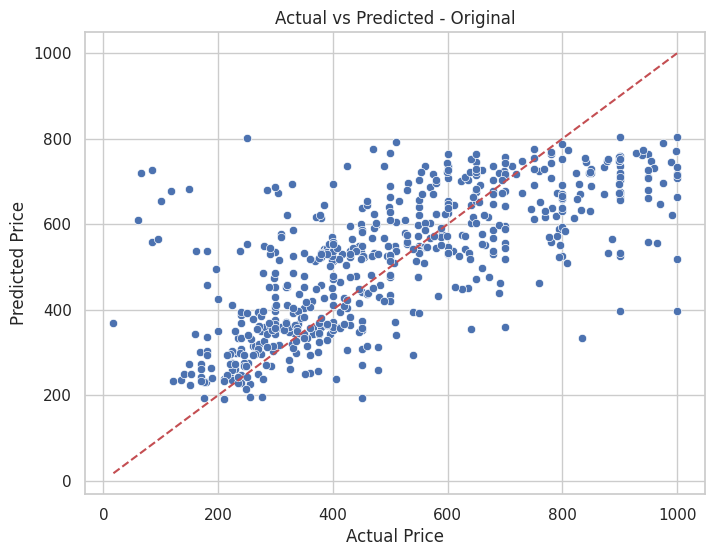

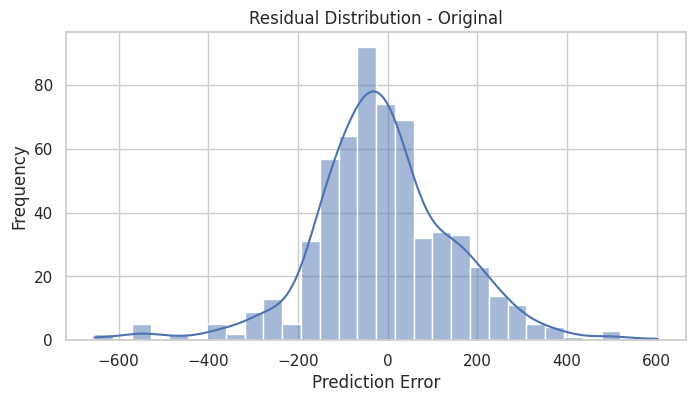

--- Global Mode Imputation ---
MSE : 25409.10
RMSE : 159.40
R² : 0.50


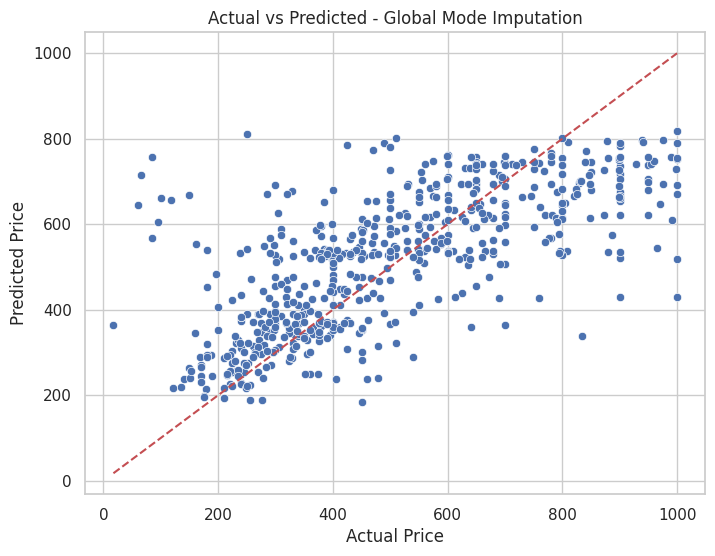

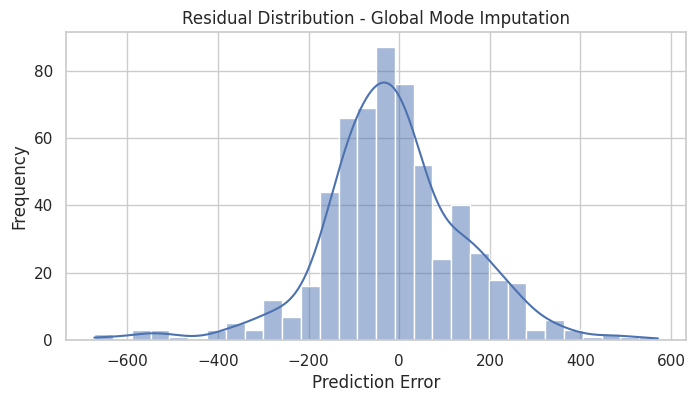

--- Screen Size Imputation ---
MSE : 29425.91
RMSE : 171.54
R² : 0.46


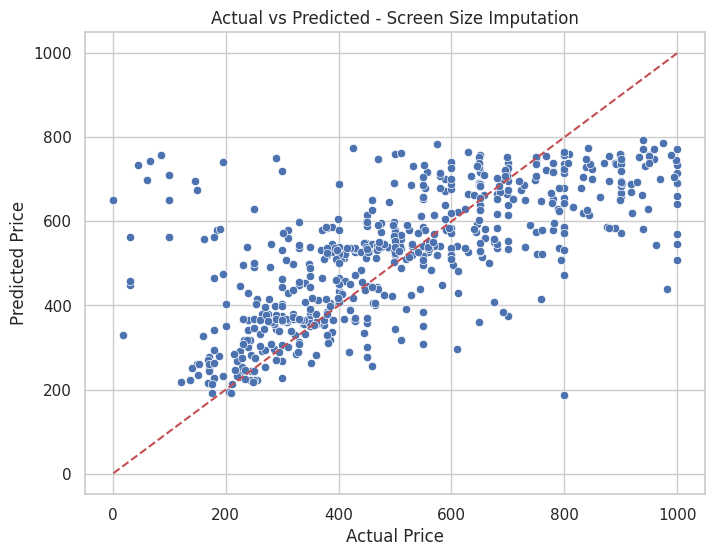

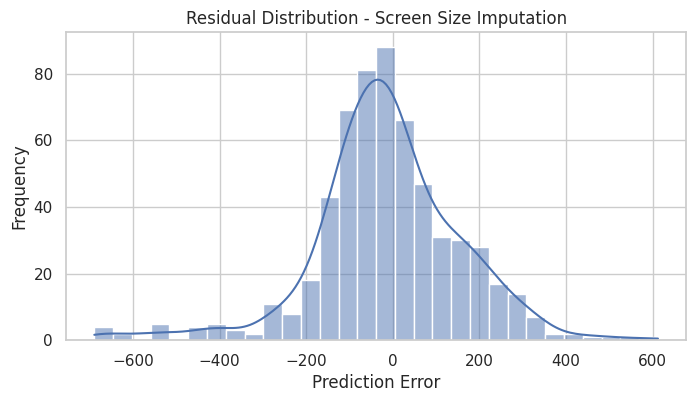

--- Predictive Imputation ---
MSE : 31132.28
RMSE : 176.44
R² : 0.46


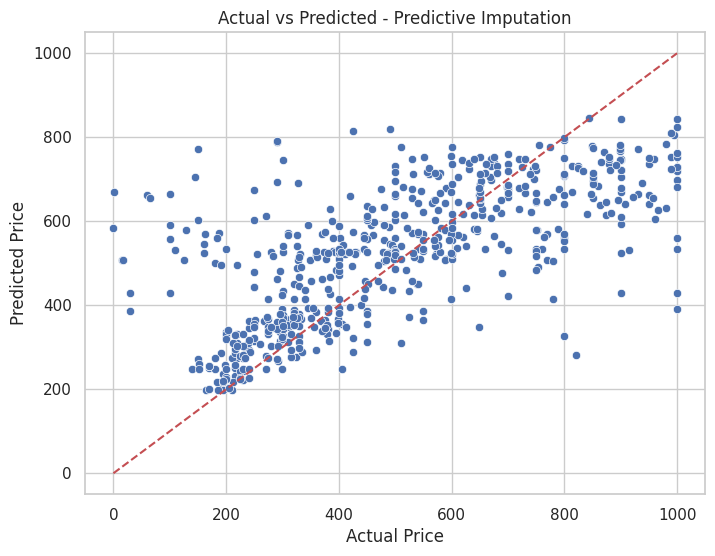

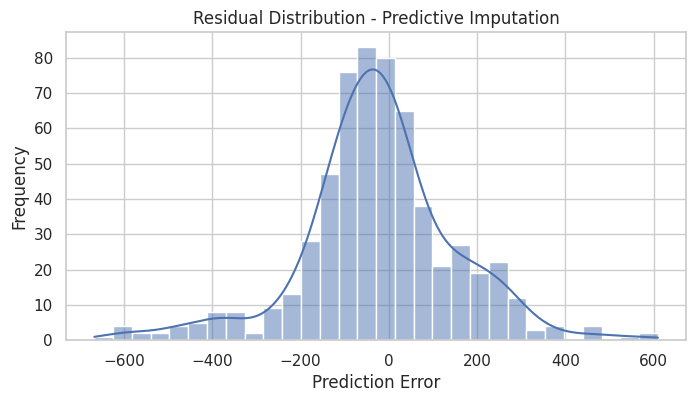

In [124]:
for name, dataset in datasets.items():
    evaluate_rf_model(dataset, name)

As for the previous method, the original dataset and the one imputed by global mode offer the best predictive performance than the methods of imputation by screen size and by predictive model.

## Gradient Boosting

Gradient Boosting Regressor: Another ensemble method that builds trees sequentially, where each new tree corrects the errors of the previous one. It tends to perform well on complex datasets

In [125]:
def evaluate_gb_model(df, title):
    df_model = df.copy()

    # One-hot encoding of categorical columns
    columns_to_encode = [
        'Resolution', 'Processor_Type', 'Processor_Gen', 'Condition',
        'GPU_Type', 'Brand', 'Screen_Size', 'Processor_Brand', 'GPU_Brand'
    ]
    for column in columns_to_encode:
        df_model = pd.get_dummies(df_model, columns=[column], prefix=column, dummy_na=True)

    # Remove rows with remaining NaNs
    df_model.dropna(inplace=True)

    # Separate X and y
    X = df_model.drop(columns=['Price'])
    y = df_model['Price']

    # Split into training and testing
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Train Gradient Boosting model
    gb_model = GradientBoostingRegressor(random_state=42)
    gb_model.fit(X_train, y_train)
    gb_preds = gb_model.predict(X_test)

    # Performance metrics
    mse = mean_squared_error(y_test, gb_preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, gb_preds)

    print(f"--- {title} ---")
    print(f"MSE : {mse:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"R² : {r2:.2f}")

    # Plot: Actual vs Prediction
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=gb_preds)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title(f"Actual vs Predicted - {title}")
    plt.grid(True)
    plt.show()

    # Plot: Residual distribution
    residuals = y_test - gb_preds
    plt.figure(figsize=(8, 4))
    sns.histplot(residuals, bins=30, kde=True)
    plt.title(f"Residual Distribution - {title}")
    plt.xlabel("Prediction Error")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

--- Original ---
MSE : 25421.62
RMSE : 159.44
R² : 0.50


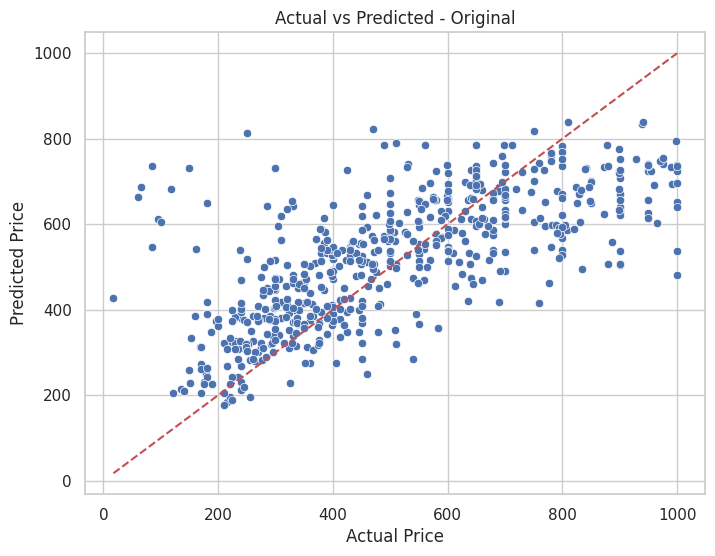

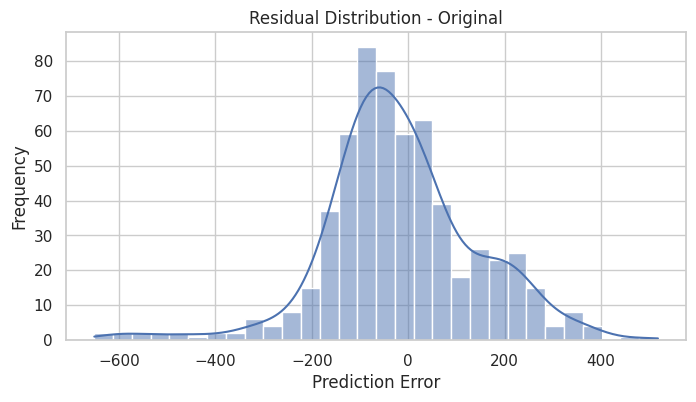

--- Global Mode Imputation ---
MSE : 25813.00
RMSE : 160.66
R² : 0.49


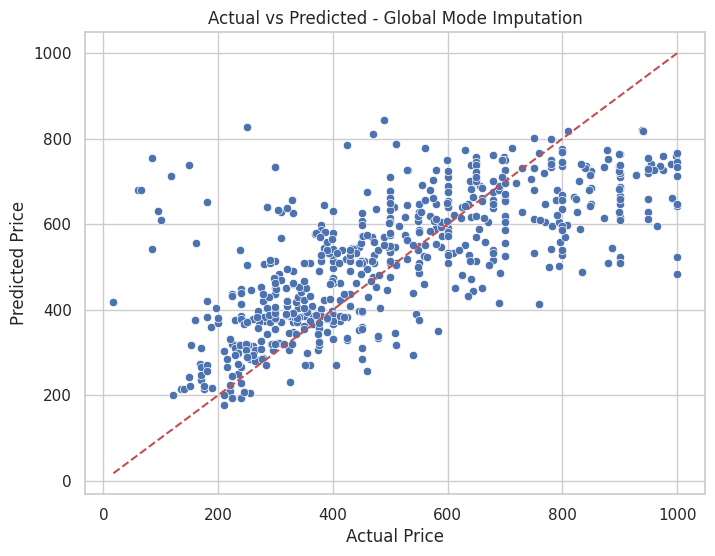

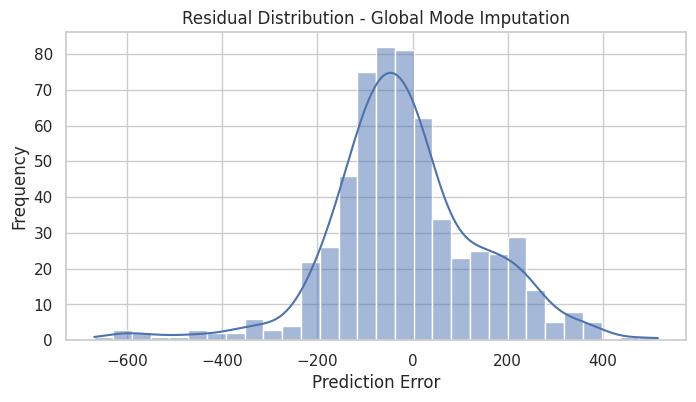

--- Screen Size Imputation ---
MSE : 30872.20
RMSE : 175.70
R² : 0.43


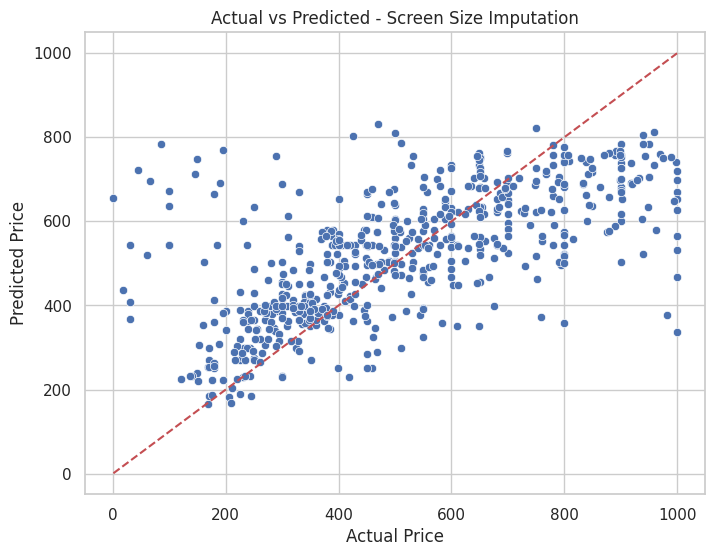

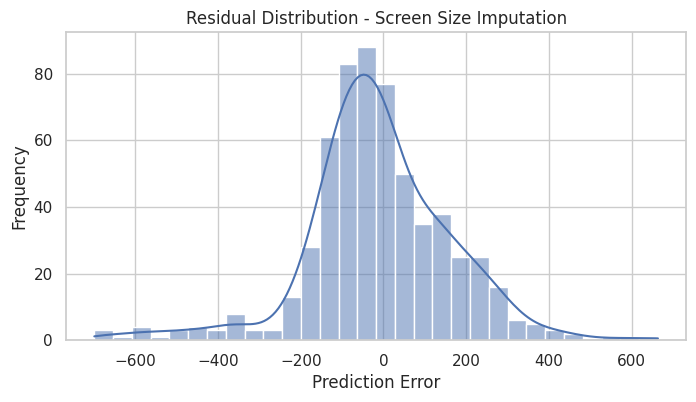

--- Predictive Imputation ---
MSE : 31194.82
RMSE : 176.62
R² : 0.46


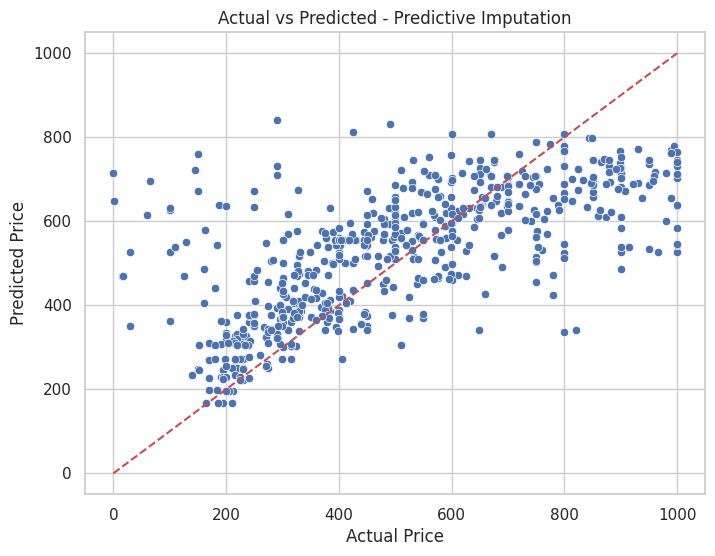

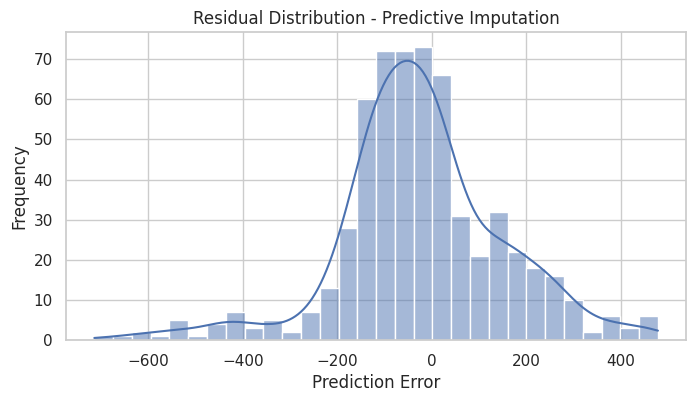

In [126]:
for name, dataset in datasets.items():
    evaluate_gb_model(dataset, name)

Similar to the previous method, the original dataset offers better predictive performance than the imputation methods.

## KNN

K-Nearest Neighbors Regressor (KNN): A non-parametric model that predicts the price based on the average of the k closest data points. The optimal value of k was determined through testing

In [129]:
def evaluate_knn_model(df, title):
    df_model = df.copy()

    # One-hot encoding
    columns_to_encode = [
        'Resolution', 'Processor_Type', 'Processor_Gen', 'Condition',
        'GPU_Type', 'Brand', 'Screen_Size', 'Processor_Brand', 'GPU_Brand'
    ]
    for column in columns_to_encode:
        df_model = pd.get_dummies(df_model, columns=[column], prefix=column, dummy_na=True)

    df_model.dropna(inplace=True)

    # Define X and y
    X = df_model.drop(columns=['Price'])
    y = df_model['Price']

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Grid search for best k
    print(f"\n--- K-NN ({title}) ---")
    k_range = range(1, 50)
    rmse_scores = []

    for k in k_range:
        knn_model = KNeighborsRegressor(n_neighbors=k)
        knn_model.fit(X_train_scaled, y_train)
        knn_preds = knn_model.predict(X_test_scaled)
        rmse = np.sqrt(mean_squared_error(y_test, knn_preds))
        rmse_scores.append(rmse)

    # Plot RMSE vs k
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, rmse_scores, marker='o')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('RMSE')
    plt.title(f'RMSE vs Number of Neighbors - {title}')
    plt.grid(True)
    plt.show()

    # Best k
    best_k = k_range[np.argmin(rmse_scores)]
    print(f"Best k found: {best_k} with RMSE = {min(rmse_scores):.2f}")

    # Retrain with best k
    knn_best = KNeighborsRegressor(n_neighbors=best_k)
    knn_best.fit(X_train_scaled, y_train)
    knn_preds = knn_best.predict(X_test_scaled)

    # Metrics
    mse = mean_squared_error(y_test, knn_preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, knn_preds)

    print(f"MSE : {mse:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"R² : {r2:.2f}")

    # Real vs Predicted
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=knn_preds)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title(f"Actual vs Predicted - {title} (k={best_k})")
    plt.grid(True)
    plt.show()

    # Residuals
    residuals = y_test - knn_preds
    plt.figure(figsize=(8, 4))
    sns.histplot(residuals, bins=30, kde=True)
    plt.title(f"Residual Distribution - {title} (k={best_k})")
    plt.xlabel("Prediction Error")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()


--- K-NN (Original) ---


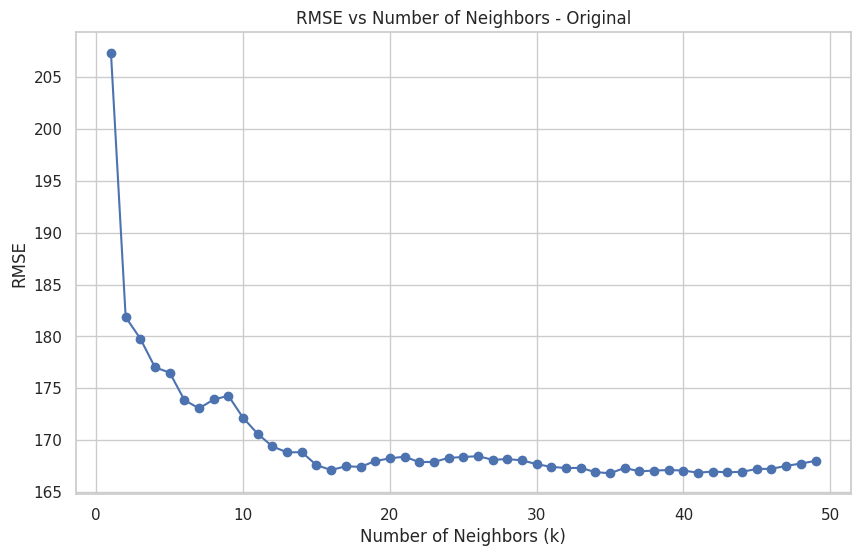

Best k found: 35 with RMSE = 166.82
MSE : 27829.54
RMSE : 166.82
R² : 0.45


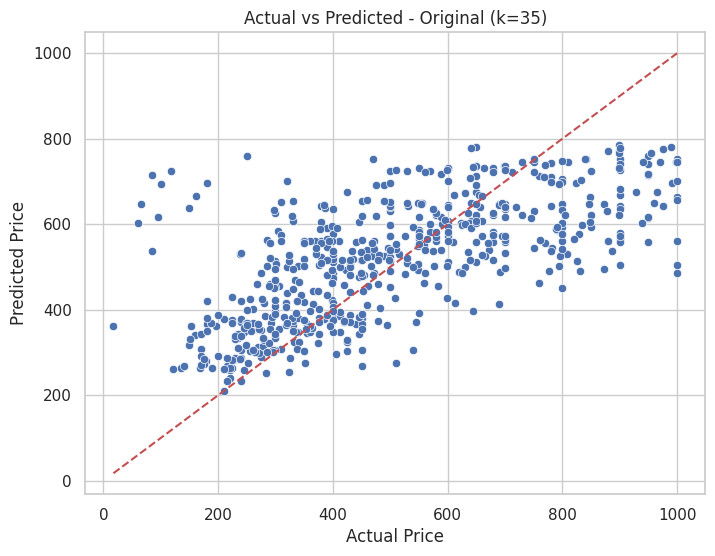

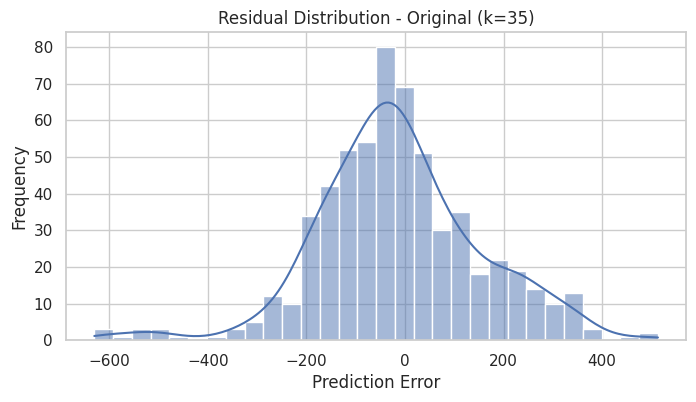


--- K-NN (Global Mode Imputation) ---


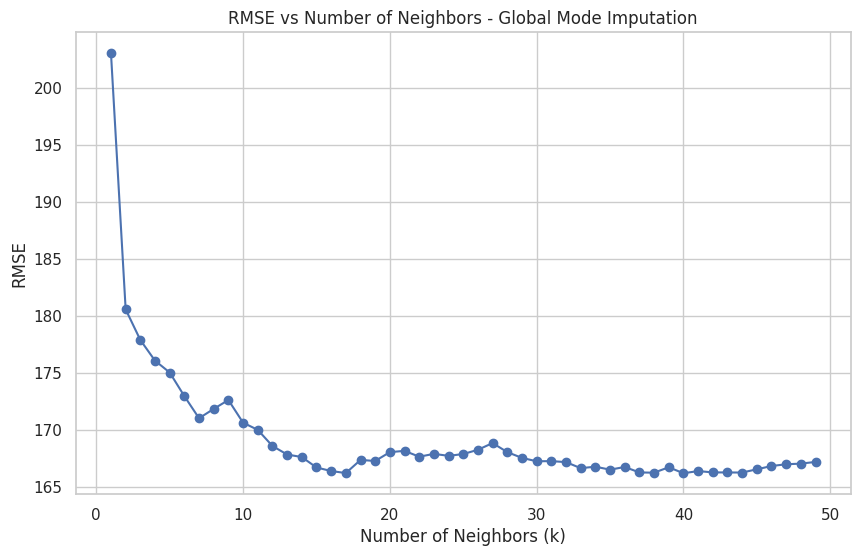

Best k found: 40 with RMSE = 166.23
MSE : 27631.60
RMSE : 166.23
R² : 0.45


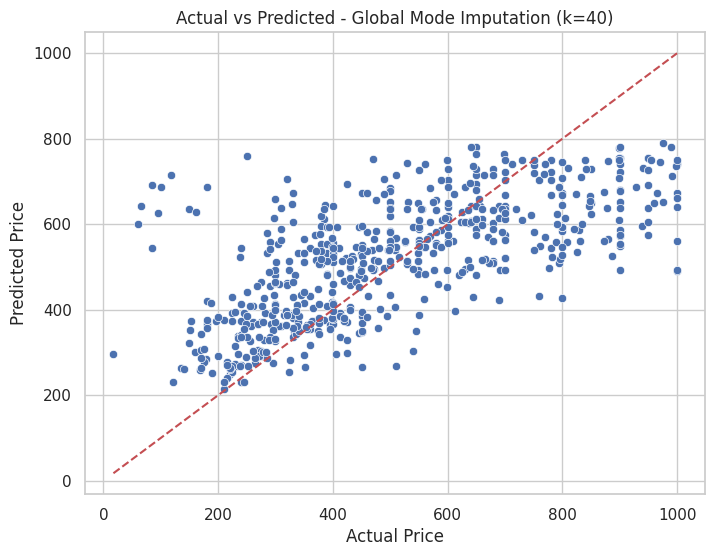

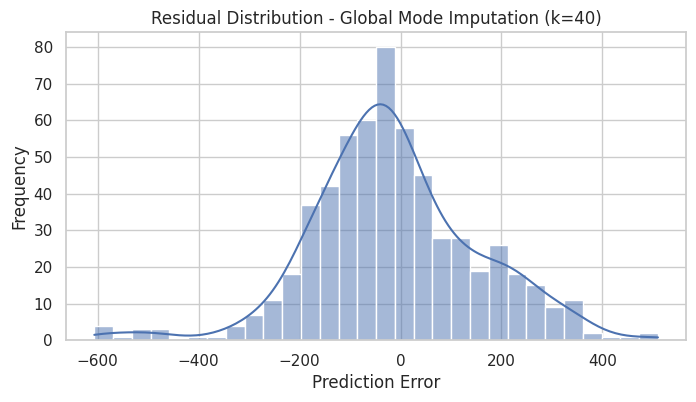


--- K-NN (Screen Size Imputation) ---


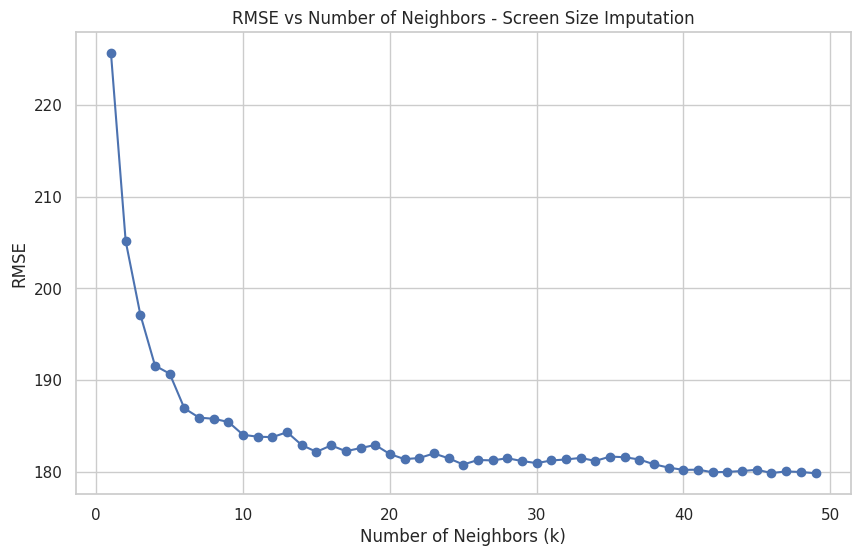

Best k found: 49 with RMSE = 179.86
MSE : 32349.70
RMSE : 179.86
R² : 0.40


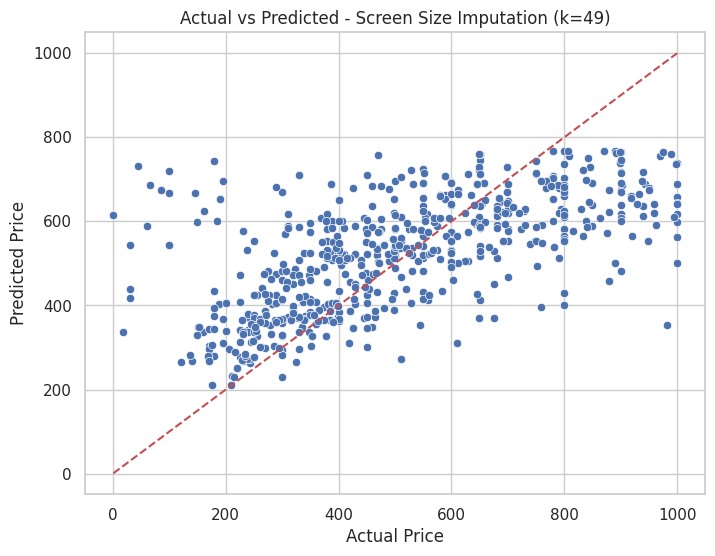

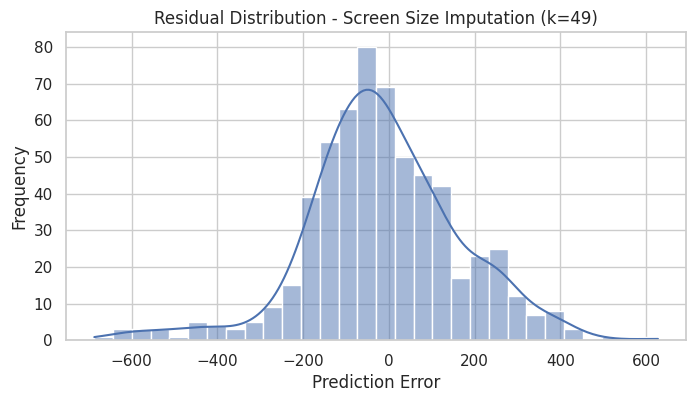


--- K-NN (Predictive Imputation) ---


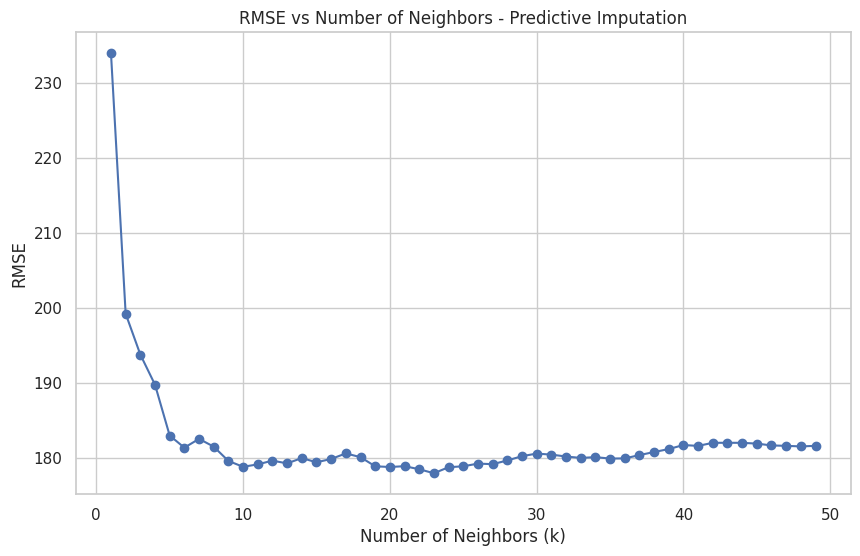

Best k found: 23 with RMSE = 177.99
MSE : 31679.30
RMSE : 177.99
R² : 0.45


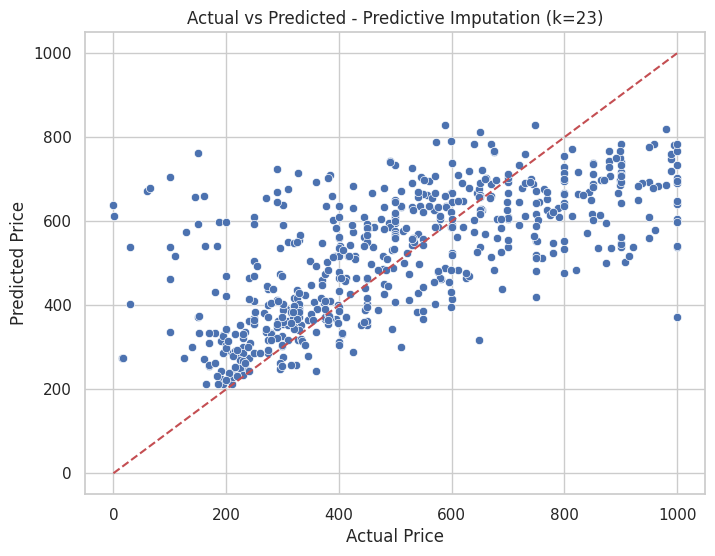

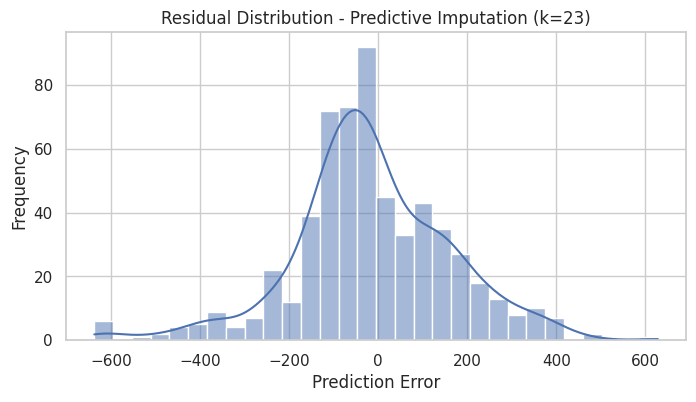

In [130]:
for name, dataset in datasets.items():
    evaluate_knn_model(dataset, name)

As for the previous method, the original dataset and the one imputed by global mode offer the best predictive performance than the methods of imputation by screen size and by predictive model.

## Interpretation of results

Each model's performance was evaluated using the following metrics :

    1 - Mean Squared Error (MSE): Measures the average squared difference between predicted and actual values. Lower values indicate better performance
    2 - R² Score (Coefficient of Determination): Indicates how well the model explains the variance in the target variable. A score closer to 1 means better performance
    3 - Root Mean Squared Error (RMSE): The square root of MSE, providing error in the same units as the target (price), which makes it easier to interpret

The performance of the regression models was not very convincing. With a Mean Squared Error (MSE) of around 25,000, an R² score of only 0.50, and a Root Mean Squared Error (RMSE) of approximately 160, the models are only able to explain about half of the variance in laptop prices.

Regarding the impact of the results due to data imputation, it was found that the original dataset and the global mode imputation offer the best predictive performance compared to the screen size and predictive model imputation methods. This trend was observed for all regression techniques used - including Linear Regression, Random Forest, Gradient Boosting and K-Nearest Neighbors - suggesting that the more complex imputations did not improve, and in some cases slightly degraded, the overall predictive power. This may indicate that either the additional structure introduced by these imputations does not adjust well to price variability, or that they introduced noise rather than informative patterns.   

## Classification Models 

    1 - Logistic Regression: A fundamental classification algorithm that models the probability of a data point belonging to a particular class
    2 - Random Forest Classifier: An ensemble learning method that builds multiple decision trees and combines their results to make more accurate and stable predictions

In [131]:
X = df.drop('Price', axis=1)
y_raw = df['Price']

def price_category(p):
    if p < 325:
        return 0
    elif p < 489:
        return 1
    elif p < 699:
        return 2
    else:
        return 3

y = y_raw.apply(price_category)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

base_model = LogisticRegression(max_iter=1000)
ovr_model = OneVsRestClassifier(base_model)

ovr_model.fit(X_train, y_train)

y_pred = ovr_model.predict(X_test)

print("\n--- Logistic Regression ---")
print(classification_report(y_test, y_pred, target_names=["Cheap", "Medium", "Bit-expensive", "High-end"]))

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Cheap", "Medium", "Bit-expensive", "High-end"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.show()

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

rf_preds = rf_model.predict(X_test)

print("\n--- Random Forest ---")
print(classification_report(y_test, rf_preds, target_names=["Cheap", "Medium", "Bit-expensive", "High-end"]))

cm = confusion_matrix(y_test, rf_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Cheap", "Medium", "Bit-expensive", "High-end"])
disp.plot(cmap=plt.cm.Greens)
plt.title("Confusion Matrix - Random Forest")
plt.show()

ValueError: could not convert string to float: 'HP'

## Confusion Matrix Interpretation:

The confusion matrix provides a detailed breakdown of the classification model’s predictions compared to the true labels. In this case, the matrix displays a strong diagonal pattern from the top-left to the bottom-right corner, which indicates that most predictions are correctly classified.

The Random Forest classifier outperformed Logistic Regression, achieving higher accuracy (58% vs. 51%) and better overall precision, recall, and F1-scores across most categories. Logistic Regression struggled particularly with the "Bit-expensive" class, showing low recall (0.23), while Random Forest handled class imbalances better, especially for "High-end" laptops (recall 0.73). Overall, predictions are decent but still leave room for improvement, especially in distinguishing between mid-range categories.